In [12]:
from comchoice.aggregate import divisiveness, win_rate, copeland, borda
from helpers import using_preflib
import argparse
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import random
import seaborn as sns

# This is a Toy Example for Experiment 3
We copied the function `get_manipulation()` from `run_manipulation.py` in order to generate the data for this example. The parameters are defined below.

In [2]:
def get_manipulation(
    agents_initial_size=100,
    n_alternatives=10,
    max_agents=1000,
    method_name="copeland",
    starting_issue=10,
    step=10,
    _type="UM10"
):
    i = 1
    method_kws = dict() if method_name == "copeland" else dict(score="weighted")
    method = copeland if method_name == "copeland" else borda

    output_divisiveness = []

    data = using_preflib(
        number_proposals=n_alternatives,
        number_individuals=agents_initial_size,
        type_=_type
    )

    alternatives = data[0]
    data = [">".join(map(str, x)) for x in data]

    df = pd.DataFrame(data, columns=["ballot"])
    df["voter"] = range(df.shape[0])

    voter = agents_initial_size * 1

    df_dv = divisiveness(
        df,
        dtype="ballot",
        convert_pairwise_kws=dict(),
        method=method,
        method_kws=method_kws
    )

    df_dv["size"] = agents_initial_size
    df_dv["iteration"] = 0

    alternative_id_manipulate = starting_issue - 1

    alternative_id = df_dv["alternative"].unique()[alternative_id_manipulate]
    df_dv["custom_id"] = range(1, df_dv.shape[0] + 1)
    df_dv["alternative_of_interest"] = df_dv["alternative"] == alternative_id

    rank = method(df)
    custom_id = df_dv[["custom_id", "alternative"]]

    output_divisiveness.append(df_dv)

    rank = rank[rank["alternative"].astype(str) != str(alternative_id)]
    alternatives_rmv = list(rank["alternative"])

    while i <= max_agents:
        # If i is odd
        if i % 2 == 1:
            ballot = ">".join(map(str, [alternative_id] + alternatives_rmv))
            df2 = pd.DataFrame({"ballot": [ballot], "voter": [voter]})
            df = pd.concat([df, df2], ignore_index=True)
        else:
            ballot = ">".join(map(str, alternatives_rmv + [alternative_id]))
            df2 = pd.DataFrame({"ballot": [ballot], "voter": [voter]})
            df = pd.concat([df, df2], ignore_index=True)

        if i % step == 0 and i > 1:

            df_dv = divisiveness(
                df,
                dtype="ballot",
                convert_pairwise_kws=dict(),
                method=method,
                method_kws=method_kws
            )
            df_dv["size"] = voter
            df_dv["alternative_of_interest"] = df_dv["alternative"] == alternative_id
            df_dv = pd.merge(df_dv, custom_id, on="alternative")
            df_dv["iteration"] = i

            output_divisiveness.append(df_dv)

        voter += 1
        i += 1

    df_manipulation = pd.concat(output_divisiveness)
    df_manipulation["starting_id"] = starting_issue
    df_manipulation["type"] = _type

    return df_manipulation

Here, we define the parameters to initialize the heuristic. It should be noted that we create 3 profiles, for 5 issues. In this case, the heuristic is initialized with Copeland.

In [14]:
n_iterations = 3 # Number of profiles to generate
_type = "IC" # Method to run. Options are "IC", "UM10", "UM50"
max_agents = 100 # Exit condition. Max number of agents to be added.
n_alternatives = 5 # Number of issues.
starting_issue = 5 # Issue in which we want to manipulate its ranking of divisiveness
step = 10 # Number of agents to be added before calculating divisiveness

output = []
for iteration in range(n_iterations):
    dd = get_manipulation(
        _type=_type,
        max_agents=max_agents,
        n_alternatives=n_alternatives,
        starting_issue=starting_issue,
        step=step
    )

    output.append(dd)

df = pd.concat(output, ignore_index=True)
df["percentage"] = (df["size"] - 100) / 100
df.head()

100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


,alternative,value,rank,size,iteration,custom_id,alternative_of_interest,starting_id,type,percentage
0,0,1.0,1,100,0,1,False,5,IC,0.0
1,1,1.0,1,100,0,2,False,5,IC,0.0
2,3,1.0,1,100,0,3,False,5,IC,0.0
3,4,1.0,1,100,0,4,False,5,IC,0.0
4,2,1.0,1,100,0,5,True,5,IC,0.0


Next, we visualize the results as similar to the figure 3

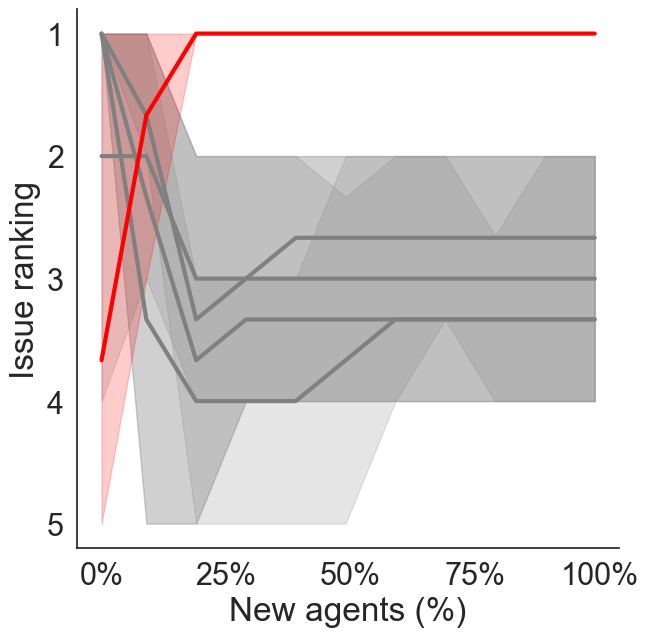

In [16]:
sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(7, 7))
palette = {c:"red" if c==starting_issue else "grey" for c in df.custom_id.unique()}

g = sns.lineplot(
    x="percentage",
    y="rank",
    palette=palette,
    hue="custom_id",
    lw=3,
    data=df,
    legend=False,
    ax=ax
)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_xlabel("New agents (%)")
ax.set_ylabel("Issue ranking")
# ax.set_title(f"{voting.title()}, {n_alternatives} issues, {method}")
ax.invert_yaxis()
sns.despine()